<a href="https://colab.research.google.com/github/eugenetwc/Medium-Notebooks/blob/master/arima_hierarchical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA for Hierarchical Time Series Forecasting

References:
- https://github.com/carlomazzaferro/scikit-hts-examples/blob/master/notebooks/M5.ipynb

## Stationarity

In [52]:
import datapane as dp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
import pmdarima as pm

sns.set_theme()

import warnings
warnings.filterwarnings("ignore")

In [2]:
date = pd.date_range(start='2020-01-01', end='2020-09-01', freq='D')
y_stationary_1 = np.random.normal(0, 10, size=date.shape)
df_stationary_1 = pd.DataFrame({'y': y_stationary_1}, index=date)
df_stationary_1.head()

,y
2020-01-01,21.050223
2020-01-02,-5.485218
2020-01-03,-1.229371
2020-01-04,4.859050
2020-01-05,-9.935211


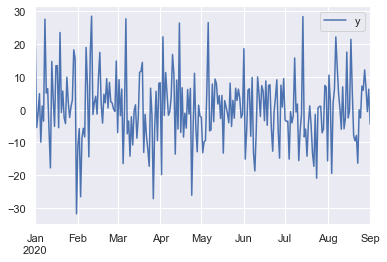

In [3]:
stationary_1_plot = df_stationary_1.plot()

In [4]:
y_stationary_2 = np.random.normal(0, 10, size=date.shape) * np.sin(2 * np.pi * np.arange(date.shape[0]))
df_stationary_2 = pd.DataFrame({'y': y_stationary_2}, index=date)
df_stationary_2.head()

,y
2020-01-01,-0.000000e+00
2020-01-02,-2.409658e-15
2020-01-03,-3.580476e-16
2020-01-04,1.133423e-14
2020-01-05,2.601300e-15


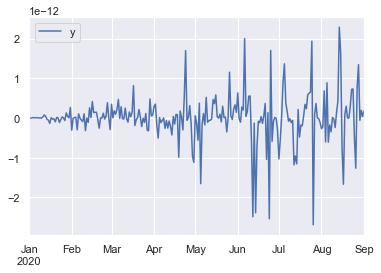

In [5]:
stationary_2_plot = df_stationary_2.plot()

# Download M5 Datset

In [51]:
!kaggle competitions download -c m5-forecasting-accuracy

m5-forecasting-accuracy.zip: Skipping, found more recently modified local copy (use --force to force download)


In [52]:
!unzip m5-forecasting-accuracy.zip

Archive:  m5-forecasting-accuracy.zip
replace calendar.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# HTS
## Transform data in the format required by scikit-hts

In [54]:
train = pd.read_csv('sales_train_validation.csv', encoding='utf-8', engine='c')

# Ensures uniqueness of category, dept, and item across hierarchie
train['cat_id']  = (train['store_id'] + '_' + train['cat_id'])
train['dept_id'] = (train['store_id'] + '_' + train['dept_id'])
train['id'] = (train['store_id'] + '_' + train['id'])

In [57]:
calendar = pd.read_csv('calendar.csv')

day_cols = [col for col in train.columns if col.startswith('d_')]
idx = [int(col.split('d_')[1]) for col in day_cols]

# will be useful later
train_date_id = pd.to_datetime(calendar[calendar.d.apply(lambda x: int(x.split('d_')[1])).isin(idx)].date)

In [60]:
def transpose(column, index, day_col):
    """
    Turn the row oriented time series into a column oriented one 
    """
    ts = []
    new_cols = train[column].unique()
    
    for value in new_cols:
        value_ts = train[train[column] == value]
        vertical = value_ts[day_col].sum().T
        vertical.index = index
        ts.append(vertical)
    return pd.DataFrame({k: v for k, v in zip(new_cols, ts)})

In [62]:
state_ts = transpose('state_id', train_date_id, day_cols)
store_ts = transpose('store_id', train_date_id, day_cols)
cat_ts = transpose('cat_id', train_date_id, day_cols)
dept_ts = transpose('dept_id', train_date_id, day_cols)
item_ts = transpose('id', train_date_id, day_cols)


In [63]:
df = pd.concat([state_ts, store_ts, cat_ts,dept_ts, item_ts], 1)

# Total column is the root node -- the sum of of all demand across all stores (we have data on, at least)
df['total'] = df['CA'] + df['TX'] + df['WI']

df.head()

,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,...,WI_3_FOODS_3_819_WI_3_validation,WI_3_FOODS_3_820_WI_3_validation,WI_3_FOODS_3_821_WI_3_validation,WI_3_FOODS_3_822_WI_3_validation,WI_3_FOODS_3_823_WI_3_validation,WI_3_FOODS_3_824_WI_3_validation,WI_3_FOODS_3_825_WI_3_validation,WI_3_FOODS_3_826_WI_3_validation,WI_3_FOODS_3_827_WI_3_validation,total
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,14195,9438,8998,4337,3494,4739,1625,2556,3852,3030,...,14,1,0,4,0,0,0,0,0,32631
2011-01-30,13805,9630,8314,4155,3046,4827,1777,2687,3937,3006,...,11,1,0,4,0,0,6,0,0,31749
2011-01-31,10108,6778,6897,2816,2121,3785,1386,1822,2731,2225,...,5,1,0,2,2,0,0,0,0,23783
2011-02-01,11047,7381,6984,3051,2324,4232,1440,2258,2954,2169,...,6,1,0,5,2,0,2,0,0,25412
2011-02-02,9925,5912,3309,2630,1942,3817,1536,1694,2492,1726,...,5,1,0,2,0,0,2,0,0,19146


In [64]:
# df.to_csv('M5_hierarchy.csv')

In [65]:
states = train.state_id.unique()
stores = train.store_id.unique()
depts = train.dept_id.unique()
cats = train.cat_id.unique()
items = train.id.unique()

# Here we build the tree as a dictionary. Each node (key in dict) has a list of 
# children value in dict, which in turn may also be a key in the dict, and have 
# children as well 
total = {'total': list(states)}
state_h = {k: [v for v in stores if v.startswith(k)] for k in states}
store_h = {k: [v for v in cats if v.startswith(k)] for k in stores}
dept_h = {k: [v for v in depts if v.startswith(k)] for k in cats}
item_h = {k: [v for v in items if v.startswith(k)] for k in depts}

In [66]:
# import json

# hierarchy = {**total, **state_h, **store_h, **dept_h, **item_h}

# with open('hierarchy.json', 'w') as j:
#     json.dump(hierarchy, j)

### A small digression
For exemplification purposes, here's what the hierarchy tree looks like. You are unlikely to need to build it yourself, it is instead built by the library automatically


In [67]:
from hts.hierarchy import HierarchyTree

ht = HierarchyTree.from_nodes(nodes=hierarchy, df=df)

# print(f'Root node: key: {ht.key}, children: {[k.key for k in ht.children]}')

# for child in ht.children:
#     print(f'{child.key} node\'s children: {[c.key for c in child]} ')

Let's print the tree from the California node:


In [70]:
# print(ht.children[0].key)

# print(ht.children[0])

You see the point. The hierarchy tree is recursively defined, and you can inspect any of the data of those nodes. For instance:

In [71]:
# observe the recursive structure
print(f'Node: {ht.children[0].children[2].children[2].key}, item: ')
ht.children[0].children[2].children[2].item

Node: CA_3_FOODS, item: 


,CA_3_FOODS
date,
2011-01-29,3446
2011-01-30,3535
2011-01-31,2701
2011-02-01,3064
2011-02-02,2761
...,...
2016-04-20,3286
2016-04-21,3056
2016-04-22,3409


## Model fitting with scikit-hts
We will be using ARIMA from the pmdarima package. scikit-hts has a wrapper for the arima model.

In [ ]:
from hts import HTSRegressor

clf = HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=4)
model = clf.fit(df, hierarchy)

Fitting models:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
preds = model.predict(step_ahead=28)

In [73]:
dp.Report(
    dp.Plot(stationary_1_plot),
    dp.Plot(stationary_2_plot),
    dp.Plot(arima_sample_plot)

).publish(name='ARIMA for Hierarchical Time Series Forecasting', open=True)

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/eugene/reports/arima-for-hierarchical-time-series-forecasting/
